In [32]:
import glob
import os,shutil,sys
import cv2
import numpy as np
import pandas as pd
from PIL import Image,ImageDraw
import matplotlib.pyplot as plt
import time #sleep 用

## 步驟6:設定閥值過濾sikulix截圖，判別有切兩刀

In [33]:
#順序，先轉成二值化閥值，僅有0或255，再將影像轉成numpy，之後遍部numpy找尋0(黑色元素)
#並且統計一條黑色元素跟兩條黑色元素的差異，來判斷有切沒切

#find_CuttingLine參數(路徑參數,要不要截圖參數)
def find_CuttingLine(file,control):
    #開檔
    img= cv2.imread(file)
    #取長寬
    #heigh,width,color=img.shape
    img= cv2.imread(file,0)
    #二值化
    ########################################
    thresh_cut=110
    image_Trunc=cv2.threshold(img,thresh_cut,255,cv2.THRESH_BINARY)[1]
    #########################################
    #分左邊右邊，辨識完全黑
    point_left_1=(0,0)
    point_left_2=(605,568)
    crop_left=image_Trunc[point_left_1[1]:point_left_2[1],point_left_1[0]:point_left_2[0]]
    
    point_right_1=(605,0)
    point_right_2=(1210,605)
    crop_right=image_Trunc[point_right_1[1]:point_right_2[1],point_right_1[0]:point_right_2[0]]
    
    #左邊右邊影像list
    count_list=[image_Trunc,crop_left,crop_right]
    name_list=['整張','左邊','右邊']
    sum_list=[]
    for i in range(len(count_list)):
        #計算當前影像長寬
        heigh,width=count_list[i].shape
        #宣告放黑色元素array
        Black_Pixel=[]
        #遍部所有pixel，0黑、255白
        for y in range(heigh):
            for x in range(width):
                #取出pixel
                pixel=count_list[i][y,x]

                #加到array
                Black_Pixel.append(pixel)
        #合併
        ary=np.array(Black_Pixel)

        #numpy轉圖
        picture=ary.reshape(heigh,width)

        #直接拿dataframe算切割線pixel
        df=pd.DataFrame(picture)
        Shape=df.shape
        total=0
        #取矩陣50%正負5區域，來計算pixel
        for row in range(int(0.45*Shape[0]),int(0.55*Shape[0])):
            for column in range(Shape[1]):
                count=(df.iloc[row,column]==0).sum()
                total+=count
        sum_list.append(total)
    ###################LOG處##########################
        #print (name_list[i],total)
    #print("==============")
    #要不要顯示圖
    if control==1:
        plt.imshow(image_Trunc,cmap='gray',aspect='auto')
        plt.show()
    ###################LOG處##########################
    
    #判斷sum_list[0]整張、sum_list[1]左邊、sum_list[2]右邊
    #0代表刪，1代表留
    if sum_list[0]>0:
        #計算差距比率，左右佔整張超過80%也要刪
        gap1=sum_list[1]/sum_list[0]
        gap2=sum_list[2]/sum_list[0]
        if gap1>0.8 or gap2>0.8:
            return 0
        #低於門檻要刪
        elif sum_list[0]<3000:
            return 0
        #左右任一邊全黑要刪
        elif sum_list[1]>9000 or sum_list[2]>9000:
            return 0
        else:
            return 1
    #完全沒pixel要刪
    else:
        return 0

## 使用步驟六，並存ok影像

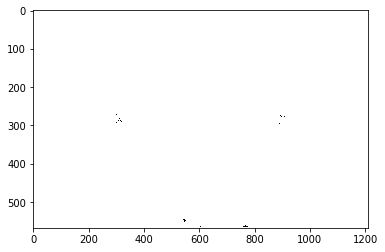

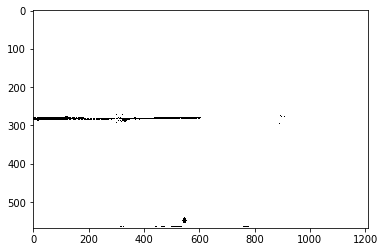

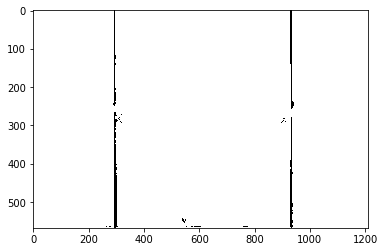

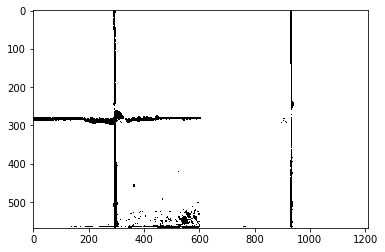

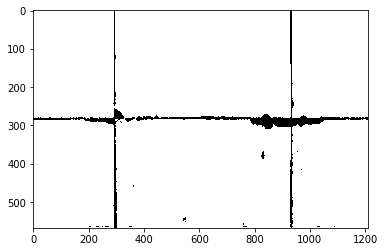

C:\Users\2102048\pythonCV\Screen\OG\temp\001.jpg
one/7HAA 資料夾篩選結果 ['C:\\Users\\2102048\\pythonCV\\Screen\\one\\7HAA\\One_004.jpg']


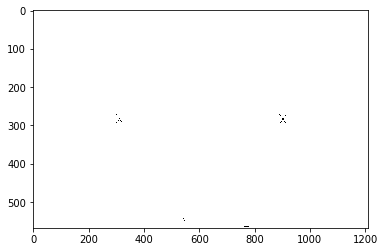

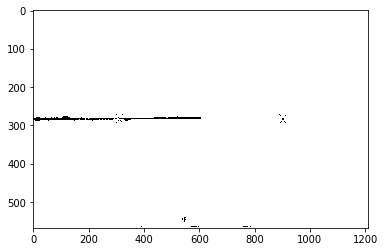

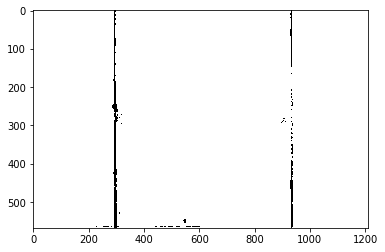

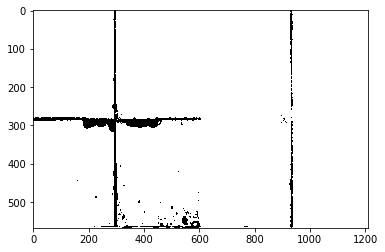

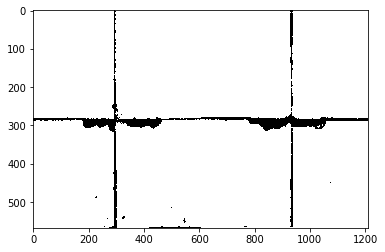

C:\Users\2102048\pythonCV\Screen\OG\temp\002.jpg
one/7KAA 資料夾篩選結果 ['C:\\Users\\2102048\\pythonCV\\Screen\\one\\7KAA\\One_004.jpg']


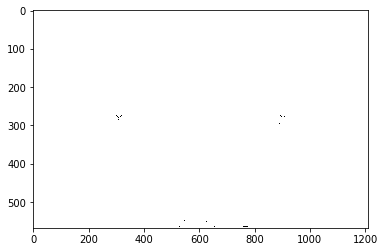

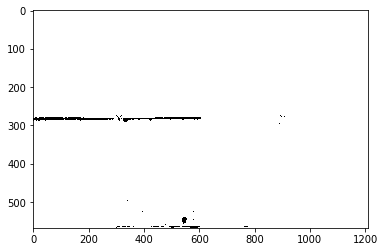

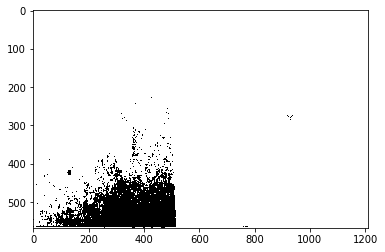

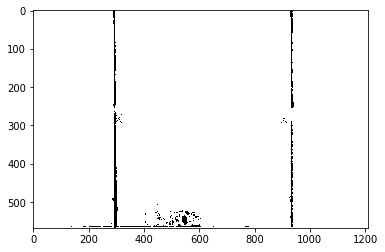

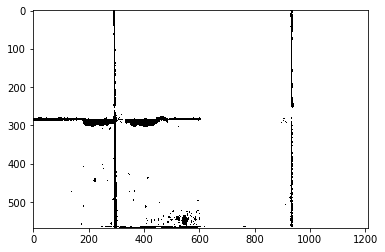

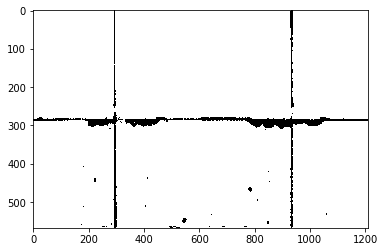

C:\Users\2102048\pythonCV\Screen\OG\temp\003.jpg
one/7LAA 資料夾篩選結果 ['C:\\Users\\2102048\\pythonCV\\Screen\\one\\7LAA\\One_005.jpg']


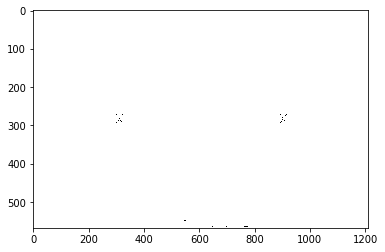

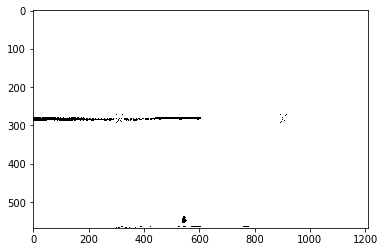

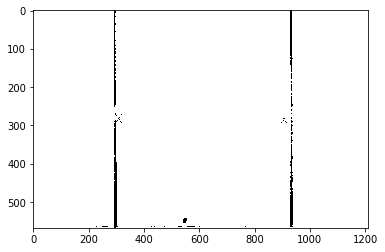

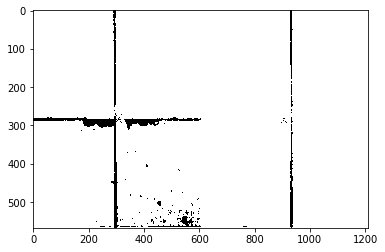

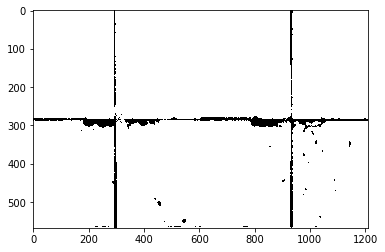

C:\Users\2102048\pythonCV\Screen\OG\temp\004.jpg
one/7NAA 資料夾篩選結果 ['C:\\Users\\2102048\\pythonCV\\Screen\\one\\7NAA\\One_004.jpg']


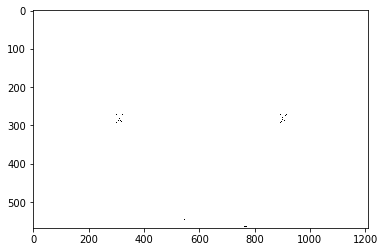

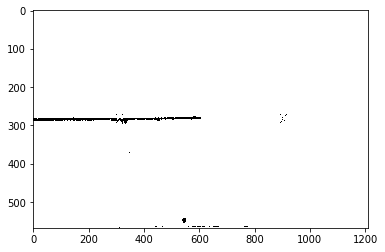

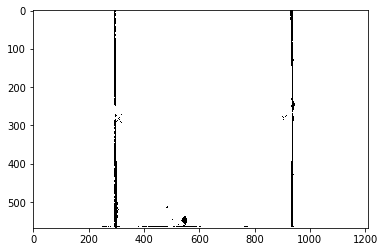

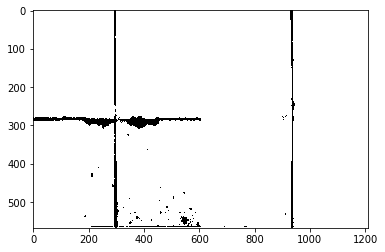

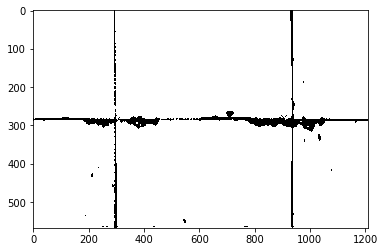

C:\Users\2102048\pythonCV\Screen\OG\temp\005.jpg
one/7PAA 資料夾篩選結果 ['C:\\Users\\2102048\\pythonCV\\Screen\\one\\7PAA\\One_004.jpg']


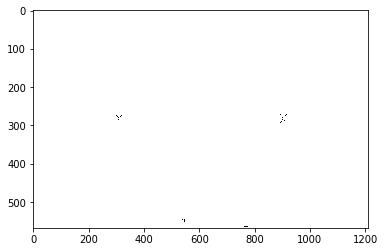

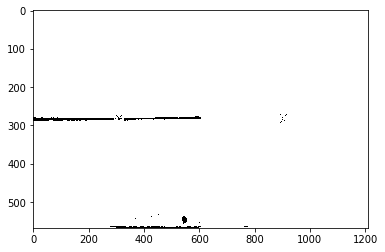

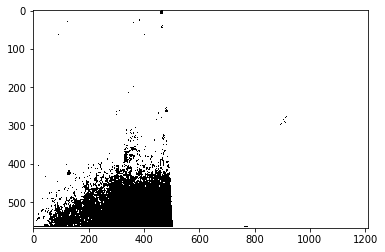

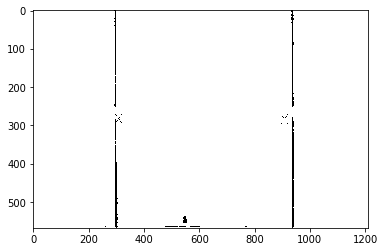

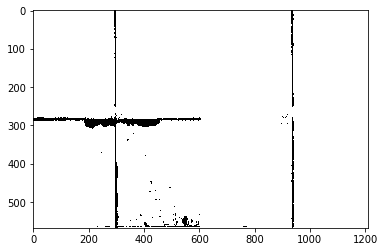

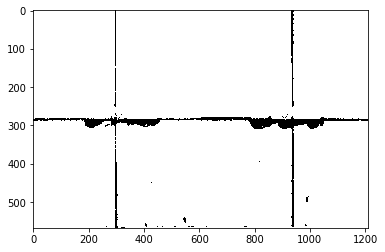

C:\Users\2102048\pythonCV\Screen\OG\temp\006.jpg
one/7QAA 資料夾篩選結果 ['C:\\Users\\2102048\\pythonCV\\Screen\\one\\7QAA\\One_006.jpg']


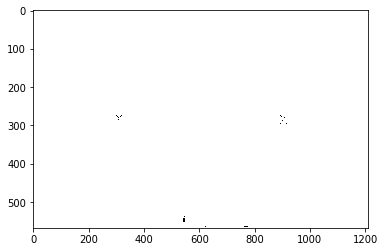

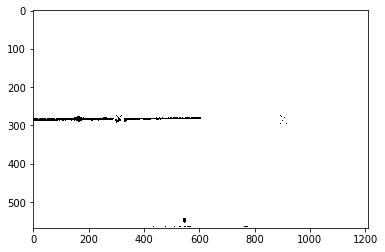

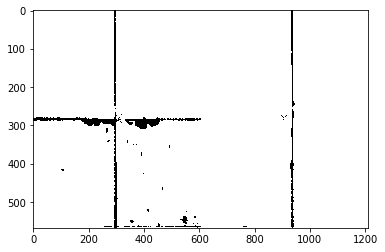

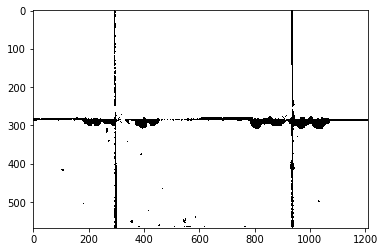

C:\Users\2102048\pythonCV\Screen\OG\temp\007.jpg
one/7RAA 資料夾篩選結果 ['C:\\Users\\2102048\\pythonCV\\Screen\\one\\7RAA\\One_003.jpg']


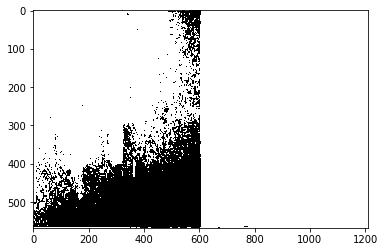

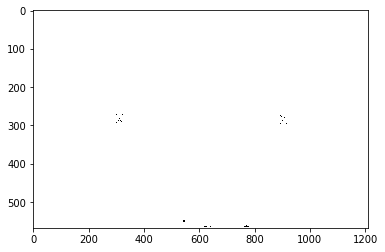

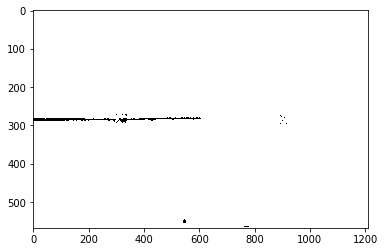

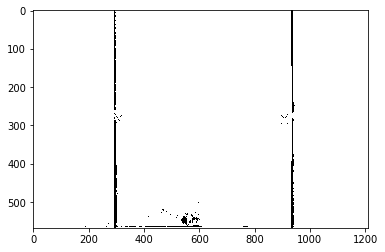

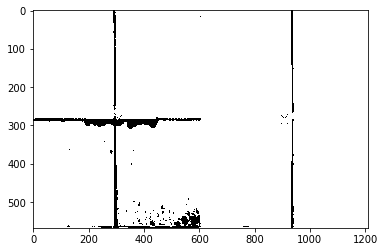

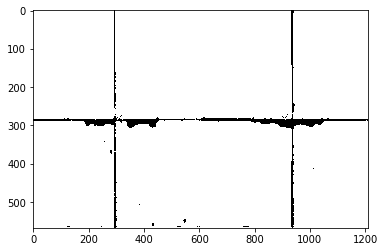

C:\Users\2102048\pythonCV\Screen\OG\temp\008.jpg
one/7SAA 資料夾篩選結果 ['C:\\Users\\2102048\\pythonCV\\Screen\\one\\7SAA\\One_005.jpg']


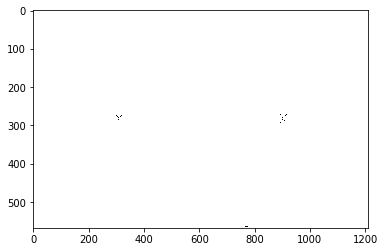

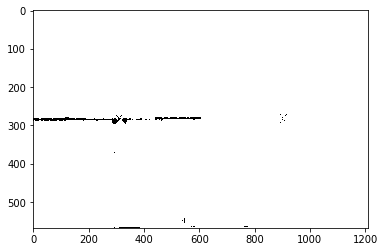

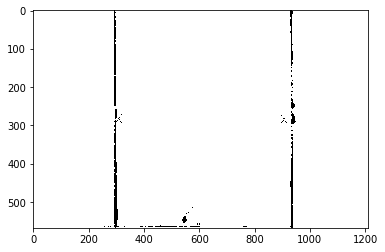

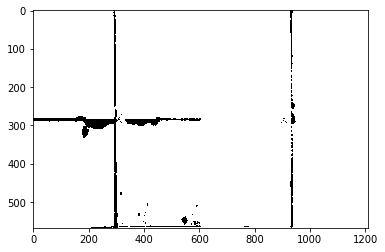

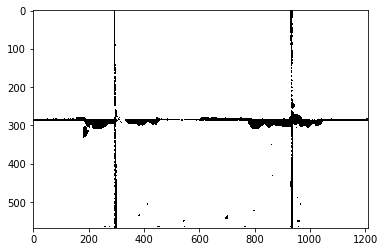

C:\Users\2102048\pythonCV\Screen\OG\temp\009.jpg
one/7TAA 資料夾篩選結果 ['C:\\Users\\2102048\\pythonCV\\Screen\\one\\7TAA\\One_004.jpg']


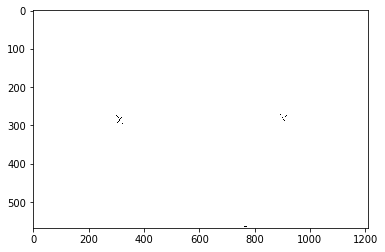

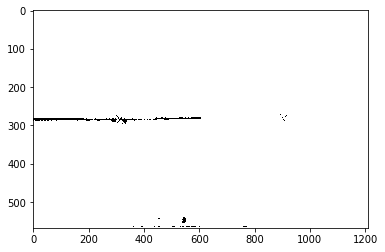

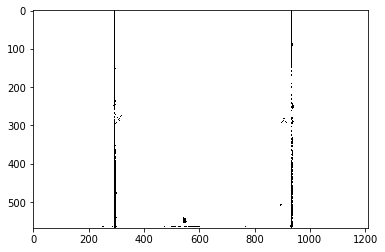

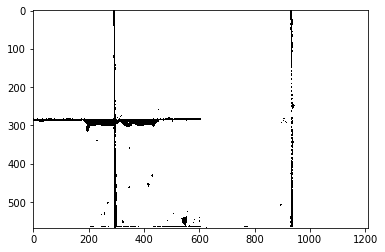

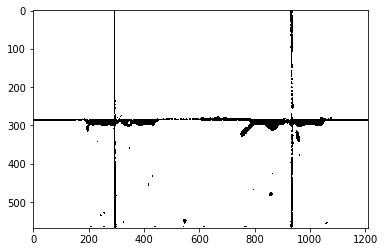

C:\Users\2102048\pythonCV\Screen\OG\temp\010.jpg
one/7UAA 資料夾篩選結果 ['C:\\Users\\2102048\\pythonCV\\Screen\\one\\7UAA\\One_004.jpg']


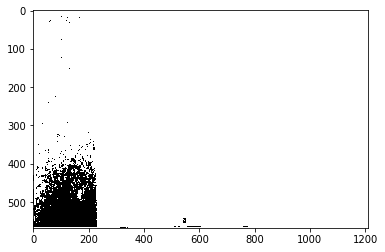

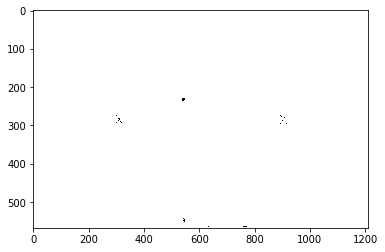

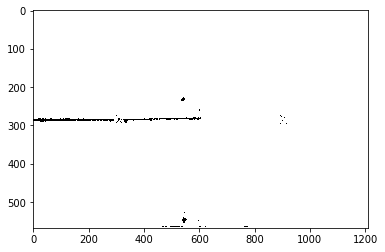

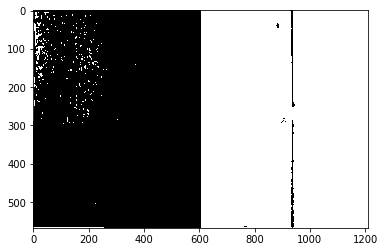

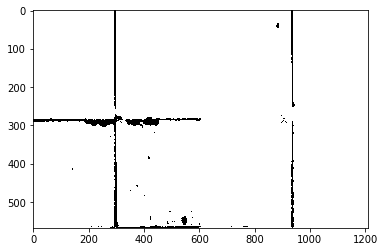

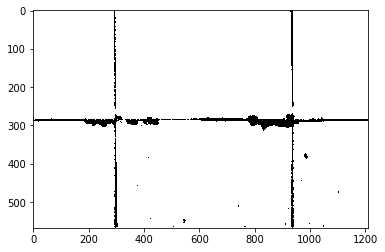

C:\Users\2102048\pythonCV\Screen\OG\temp\011.jpg
one/7VAA 資料夾篩選結果 ['C:\\Users\\2102048\\pythonCV\\Screen\\one\\7VAA\\One_005.jpg']


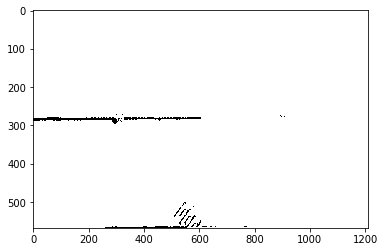

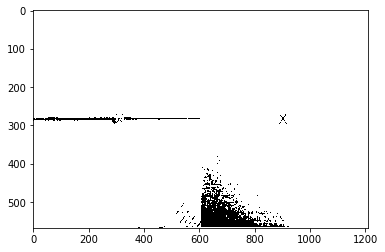

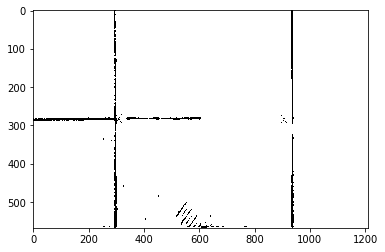

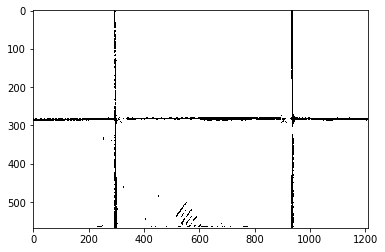

C:\Users\2102048\pythonCV\Screen\OG\temp\012.jpg
two/7HAA 資料夾篩選結果 ['C:\\Users\\2102048\\pythonCV\\Screen\\two\\7HAA\\Two_003.jpg']


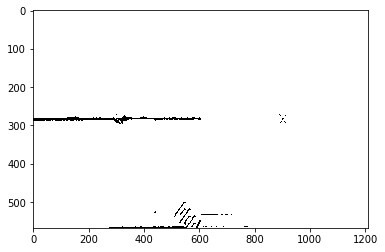

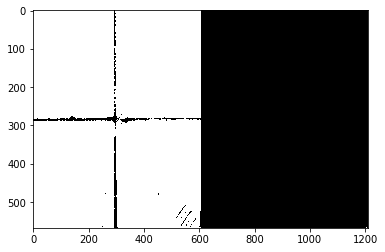

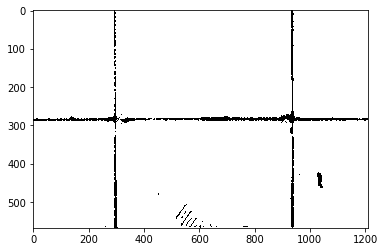

C:\Users\2102048\pythonCV\Screen\OG\temp\013.jpg
two/7KAA 資料夾篩選結果 ['C:\\Users\\2102048\\pythonCV\\Screen\\two\\7KAA\\Two_002.jpg']


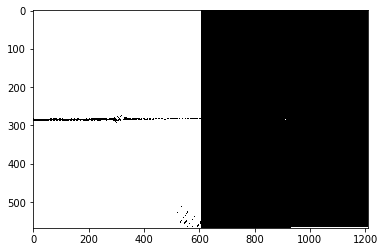

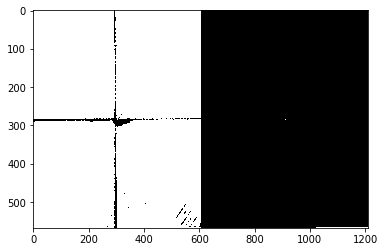

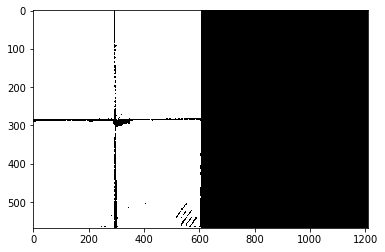

two/7LAA 資料夾篩選結果 []


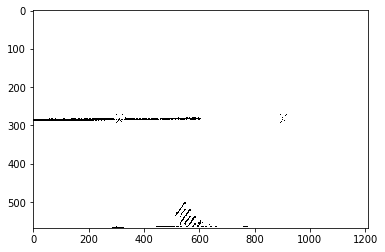

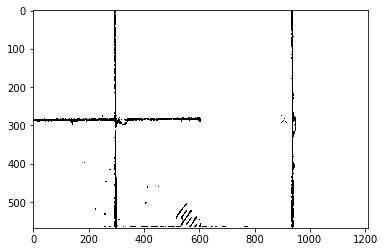

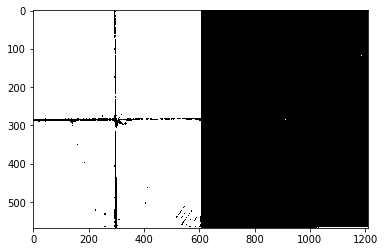

two/7NAA 資料夾篩選結果 []


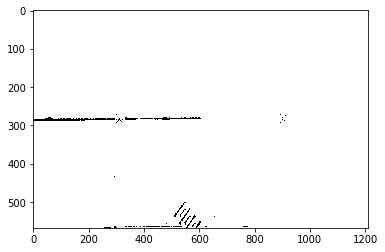

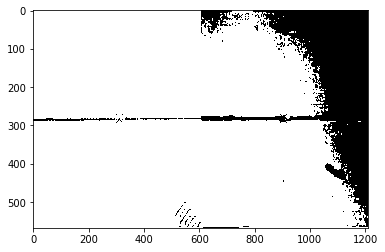

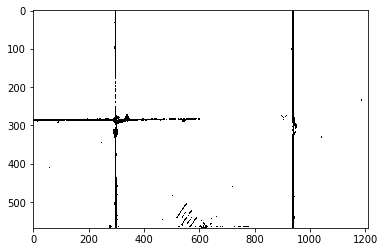

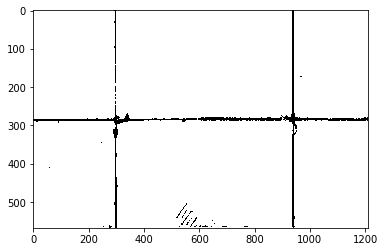

C:\Users\2102048\pythonCV\Screen\OG\temp\014.jpg
two/7PAA 資料夾篩選結果 ['C:\\Users\\2102048\\pythonCV\\Screen\\two\\7PAA\\Two_003.jpg']


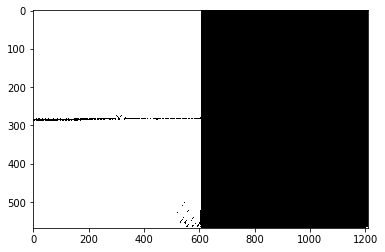

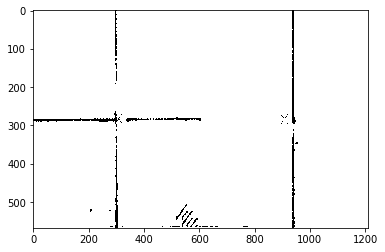

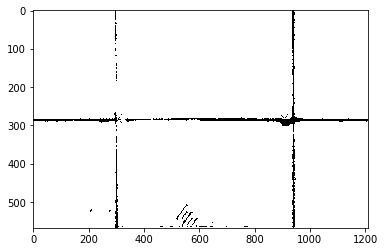

C:\Users\2102048\pythonCV\Screen\OG\temp\015.jpg
two/7QAA 資料夾篩選結果 ['C:\\Users\\2102048\\pythonCV\\Screen\\two\\7QAA\\Two_002.jpg']


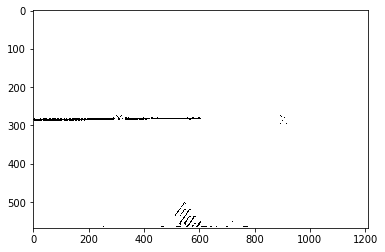

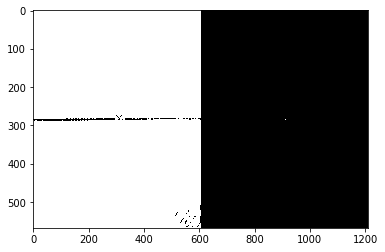

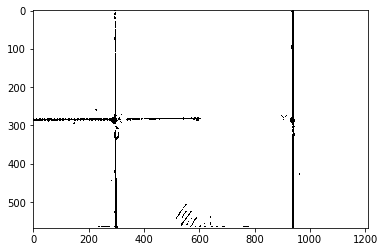

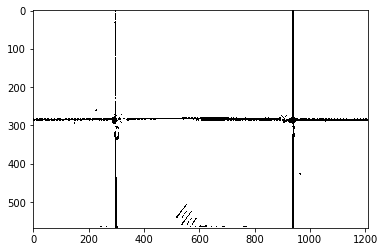

C:\Users\2102048\pythonCV\Screen\OG\temp\016.jpg
two/7RAA 資料夾篩選結果 ['C:\\Users\\2102048\\pythonCV\\Screen\\two\\7RAA\\Two_003.jpg']


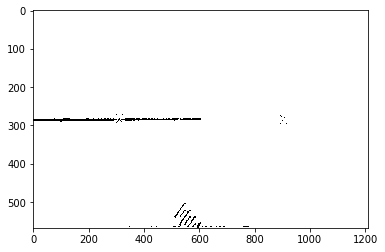

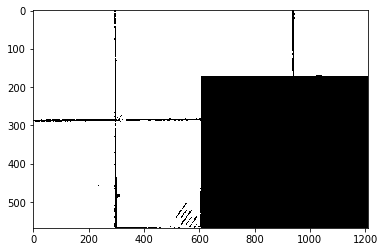

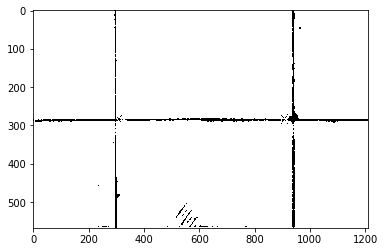

C:\Users\2102048\pythonCV\Screen\OG\temp\017.jpg
two/7SAA 資料夾篩選結果 ['C:\\Users\\2102048\\pythonCV\\Screen\\two\\7SAA\\Two_002.jpg']


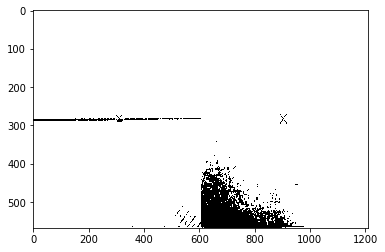

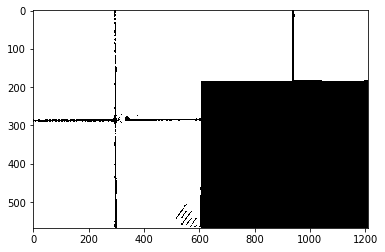

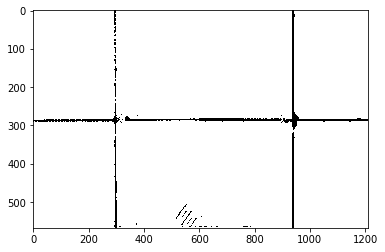

C:\Users\2102048\pythonCV\Screen\OG\temp\018.jpg
two/7TAA 資料夾篩選結果 ['C:\\Users\\2102048\\pythonCV\\Screen\\two\\7TAA\\Two_002.jpg']


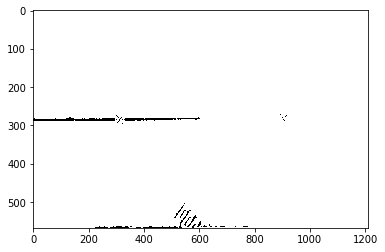

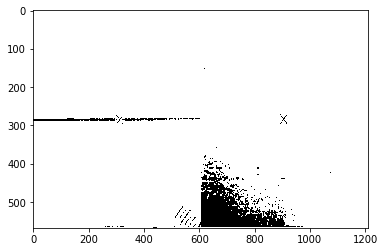

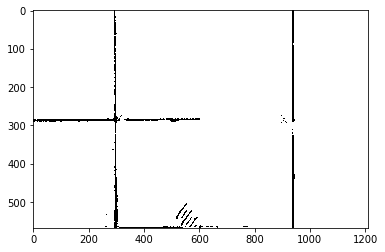

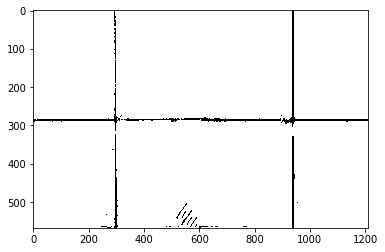

C:\Users\2102048\pythonCV\Screen\OG\temp\019.jpg
two/7UAA 資料夾篩選結果 ['C:\\Users\\2102048\\pythonCV\\Screen\\two\\7UAA\\Two_003.jpg']


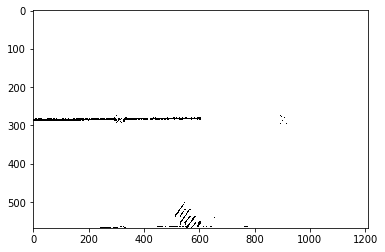

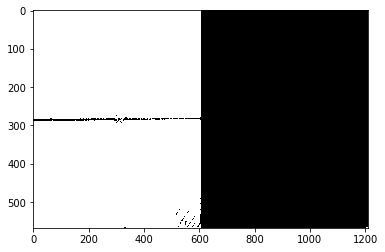

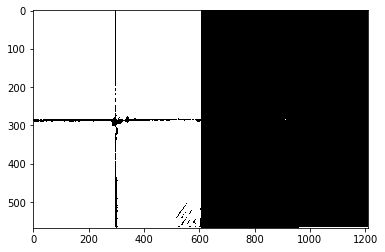

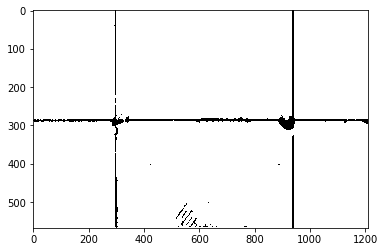

C:\Users\2102048\pythonCV\Screen\OG\temp\020.jpg
two/7VAA 資料夾篩選結果 ['C:\\Users\\2102048\\pythonCV\\Screen\\two\\7VAA\\Two_003.jpg']


In [35]:
#Use_function(Image,csv name)
#檔名流水號
number=1
file_list=['one','two']
sub_file_list=['7HAA','7KAA','7LAA','7NAA','7PAA','7QAA','7RAA','7SAA','7TAA','7UAA','7VAA']
save_list=[]
for i in range(len(file_list)):
    for j in range(len(sub_file_list)):
        save_list.clear()
        path='C:\\Users\\2102048\\pythonCV\\Screen\\'+file_list[i]+'\\'+sub_file_list[j]+'\\*'
        file=glob.glob(path +'.jpg')
        for k,f in enumerate(file):
            save=find_CuttingLine(f,1)
            if save==1:
                save_list.append(f)
        #若有重複留最後
        if len(save_list)>=1:
            final=save_list[-1]
            save_list.clear()
            save_list.append(final)
            #存檔，把其他都刪掉
            savepath='C:\\Users\\2102048\\pythonCV\\Screen\\OG\\temp'
            savepath=savepath+'\\'+str('{:0>3d}').format(number)+'.jpg'
            print(savepath)
            number+=1
            savefile=cv2.imread(save_list[0])
            cv2.imwrite(savepath,savefile)
        '''
        #刪除資料夾
        delpath='C:\\Users\\2102048\\pythonCV\\Screen\\OG\\temp'
        #整個刪掉在建立新的
        shutil.rmtree(delpath)
        os.mkdir(delpath)
        '''
        print(file_list[i]+'/'+sub_file_list[j],'資料夾篩選結果',save_list)

## 步驟7:切割左邊右邊

In [20]:
#原始資料夾,切完存的資料夾
def precutting(input_path,output_path):
    try:
        #path='C:\\Users\\2102048\\pythonCV\\Screen\\OG\\43_OG\\'
        Filelist=glob.glob(input_path+'*.jpg')
        #判斷有兩張才繼續
        if len(Filelist)==2:
            #依次讀取陣列裡面的每個檔案，並一一開啟來處理
            for i,f in enumerate(Filelist):
                #開一個檔案
                img=cv2.imread(f)
                #取檔名
                filename=(f.split('\\'))[-1]
                #去除副檔名
                name=filename[:-8]
                #設定座標取左
                #[[605,500],[0,500],[0,0],[605,0]]
                point_left_1=(0,0)
                point_left_2=(605,568)
                crop_left=img[point_left_1[1]:point_left_2[1],point_left_1[0]:point_left_2[0]]
                save_left=name+'_01.jpg'
                cv2.imwrite(output_path+save_left,crop_left)
                #設定座標取右
                #[[1210,500],[605,500],[605,0],[1210,0]]
                point_right_1=(605,0)
                point_right_2=(1210,605)
                crop_right=img[point_right_1[1]:point_right_2[1],point_right_1[0]:point_right_2[0]]
                save_right=name+'_02.jpg'
                cv2.imwrite(output_path+save_right,crop_right)
                '''
                #刪除資料夾
                #整個刪掉在建立新的
                shutil.rmtree(input_path)
                os.mkdir(input_path)
                '''
            print("分割OK")
            return 1
        else:
            return 0
    except:
        print("分割ERROR")
        return 0
precutting('C:\\Users\\2102048\\pythonCV\\Screen\\OG\\temp\\','C:\\Users\\2102048\\pythonCV\\Screen\\OG\\cut_temp\\')

分割OK


1

## 影像處理(霍夫曼取直線)

In [115]:
### 二值化&霍夫曼直線(處理過的圖像,原圖,要不要截圖)
def line(im_Bin,Im,input_path,output_path,name,control):
    try:
    ##################影像前處理###########################
        # Erosion 影像侵蝕(二值化後)
        kernel = np.ones((3,3), np.uint8)
        erosion = cv2.erode(im_Bin, kernel, iterations = 1)

        
        # #Dilation 影像膨脹(二值化後)
        kernel = np.ones((3,3), np.uint8)
        dilation = cv2.dilate(erosion, kernel, iterations = 1) #執行越多次膨脹效果越明顯

        
        #canny邊緣檢測，(處理影像,下限,下限)
        #值越小越能捕捉更多邊緣
        canny = cv2.Canny(dilation, 30, 120) #low_threshold:30, high_threshold:150
        cv2.imwrite(output_path +'Canny_'+name+input_path.split('\\')[-1], canny)
    ##################影像前處理###########################
        
        #直線檢測--霍夫直線變換
        #threshold:判斷直線點數的閾值; minLineLength：短於此的線段將被拒絕; maxLineGap 線段之間允許的最大間隙，將它們視為一條線
        lines = cv2.HoughLinesP(canny, 1, np.pi / 180, 50, minLineLength=30, maxLineGap=1) #霍夫直線變換
        lines1 = lines[:, 0, :]  # 提取為二維
        for x1, y1, x2, y2 in lines1[:]:
            if (((10<x1<470)or(10<x2<470))and((10<y1<420)or(10<y2<420))):
                cv2.line(Im, (x1, y1), (x2, y2), (0, 255, 0), 2)

        #存檔霍夫曼結果
        cv2.imwrite(output_path +'Result_'+name+input_path.split('\\')[-1],Im)

        #判斷斜率
        i=1
        vline=[]
        hline=[]
        # 對通過霍夫變換得到的資料進行遍歷
        for line in lines:
            # newlines1 = lines[:, 0, :]
            print("line["+str(i-1)+"]=",line)
            x1,y1,x2,y2 = line[0]  #兩點確定一條直線，這裡就是通過遍歷得到的兩個點的資料 （x1,y1）(x2,y2)
        #     cv2.line(img1,(x1,y1),(x2,y2),(0,0,255),2)   #在原圖上畫線
            # 轉換為浮點數，計算斜率
            x1 = float(x1)
            x2 = float(x2)
            y1 = float(y1)
            y2 = float(y2)
            print ("x1=%s,x2=%s,y1=%s,y2=%s" % (x1, x2, y1, y2))
            #判斷垂直線&定義的範圍
            if ((x2 - x1 == 0 )and(((10<x1<470)or(10<x2<470))and((10<y1<420)or(10<y2<420)))):
        #         print("line["+str(i-1)+"]=",line)
        #         print ("x1=%s,x2=%s,y1=%s,y2=%s" % (x1, x2, y1, y2))
                print ("V-Line")
                print("Lenth",y2-y1)
                result=90
                #記錄所有垂直線的x座標，最大-最小得出垂直線之間的距離
                vline.append(x1)
            #判斷水平線&定義的範圍
            '''
            elif ((y2 - y1 == 0) and (((10<x1<470)or(10<x2<470))and((10<y1<420)or(10<y2<420)))):
                print ("H-Line")
                print("Lenth",x2-x1)
                result=0
                #記錄所有水平線的y座標，最大-最小得出水平線之間的距離
                hline.append(y1)
            else:
                # 計算斜率
                k = -(y2 - y1) / (x2 - x1)
                # 求反正切，再將得到的弧度轉換為度
                result = np.arctan(k) * 57.29577
                print ("Line-Angle：" + str(result) + "degree")
            '''
            print('============================')
            i = i+1
        print('V_line_list', sorted(vline))
        print('H_line_list',sorted(hline))
        # x/y 座標，最大-最小得出垂直/水平線之間的距離
        print('V_line_gap %s pixel'% str(max(vline)-min(vline)))
        print('H_line_gap %s pixel'% str(max(hline)-min(hline)))
        #return 垂直線&水平線的中心點value，min + (max-min)/2
        return(min(vline)+float(max(vline)-min(vline))/2,float(min(hline))+float(max(hline)-min(hline))/2)
          
    #例外處理
    except ZeroDivisionError:
        print("除法數值為0")
        return 0,0
    except ValueError:
        print("輸入格式有誤")
        return 0,0
    except:
        print("程式異常")
        return 0,0
    finally:
        #顯示
        if control==1:
            titles=['Erosion','Dilation','Canny','Result']
            images=[erosion,dilation,canny,Im]
            for i in range(4):
                #row*column
                plt.subplot(2,2,i+1)
                plt.imshow(images[i],cmap='gray',aspect='auto')
                plt.title(titles[i])
            plt.show()
        

## 影像處理

In [111]:
def Image_processing_calculation(input_path,output_path,control):
    #input_path='C:\\Users\\2102048\\pythonCV\\Screen\\OG\\cut_temp\\'
    #output_path='C:\\Users\\2102048\\pythonCV\\Screen\\OG\\cut_result\\'
    file=glob.glob(input_path+'*.jpg')
    for i ,f in enumerate(file):
        input_path=f
        name=os.path.basename(input_path)
        #讀檔案原檔
        img=cv2.imread(input_path)
        
        #算長寬
        height,width,color=img.shape
        #灰階
        img_gray=cv2.cvtColor(img,cv2.COLOR_BGR2GRAY)
        #降造(高斯平滑)
        img_blurred=cv2.GaussianBlur(img_gray,(5,5),0)
        #將處理完的矩陣塞進去
        table_gray=pd.DataFrame(img_blurred.reshape(height,width))
        table_gray.to_csv(output_path+'blurred.csv')


        #二值化取mark (二值化閥水平)
        thresh_mark=150
        mark_bin=cv2.threshold(img_blurred,thresh_mark,255,cv2.THRESH_BINARY)[1]
        print("=================霍夫曼取直線(mark)=======================")
        #霍夫曼取直線(mark)，參數(二值化圖,原圖,in,out,存檔名,要不要顯示)
        mark_x,mark_y=line(mark_bin,img,input_path,output_path,'mark',1)
        print(mark_x,mark_y)


        #二值化取cut (二值化閥水平)
        thresh_cut=115
        cut_bin=cv2.threshold(img_blurred,thresh_cut,255,cv2.THRESH_BINARY)[1]
        print("=================霍夫曼取直線(cut)=======================")
        #霍夫曼取直線(cut)，參數(二值化圖,原圖,in,out,存檔名,要不要顯示)
        cut_x,cut_y=line(cut_bin,img,input_path,output_path,'cut',1)
        print(cut_x,cut_y)
        
        #輸出結果
        if cut_x>0 and cut_y>0 and mark_x>0 and mark_y>0:
            print("========================================")
            print('x切割精度:{} pixel, y切割精度:{} pixel'.format(mark_x-cut_x,mark_y-cut_y))
        else:
            print("Error 數值有負，計算錯誤")
        
        
    if control==1:
        titles=['original','blurred','bin_mark','bin_cut']
        images=[img_gray,img_blurred,mark_bin,cut_bin]
        for i in range(4):
            #row*column
            plt.subplot(2,2,i+1)
            plt.imshow(images[i],'gray')
            plt.title(titles[i])
        plt.show()

=================霍夫曼取直線(mark)=======================
line[0]= [[336 390 336 290]]
x1=336.0,x2=336.0,y1=390.0,y2=290.0
V-Line
Lenth -100.0
line[1]= [[193 246 281 246]]
x1=193.0,x2=281.0,y1=246.0,y2=246.0
line[2]= [[300 381 300 301]]
x1=300.0,x2=300.0,y1=381.0,y2=301.0
V-Line
Lenth -80.0
line[3]= [[382 246 442 245]]
x1=382.0,x2=442.0,y1=246.0,y2=245.0
line[4]= [[299 198 299 244]]
x1=299.0,x2=299.0,y1=198.0,y2=244.0
V-Line
Lenth 46.0
line[5]= [[336 156 336 203]]
x1=336.0,x2=336.0,y1=156.0,y2=203.0
V-Line
Lenth 47.0
V_line_list [299.0, 300.0, 336.0, 336.0]
H_line_list []
V_line_gap 37.0 pixel
輸入格式有誤


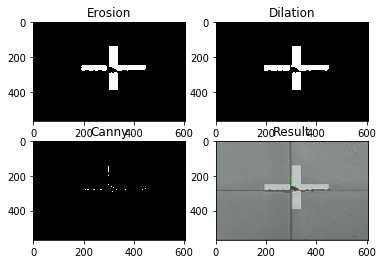

0 0
=================霍夫曼取直線(cut)=======================
line[0]= [[355 563 470 563]]
x1=355.0,x2=470.0,y1=563.0,y2=563.0
line[1]= [[291 175 291 122]]
x1=291.0,x2=291.0,y1=175.0,y2=122.0
V-Line
Lenth -53.0
line[2]= [[ 70 279 178 279]]
x1=70.0,x2=178.0,y1=279.0,y2=279.0
line[3]= [[296 210 296 169]]
x1=296.0,x2=296.0,y1=210.0,y2=169.0
V-Line
Lenth -41.0
line[4]= [[290  70 290  16]]
x1=290.0,x2=290.0,y1=70.0,y2=16.0
V-Line
Lenth -54.0
line[5]= [[148 285 184 285]]
x1=148.0,x2=184.0,y1=285.0,y2=285.0
line[6]= [[291 406 291 358]]
x1=291.0,x2=291.0,y1=406.0,y2=358.0
V-Line
Lenth -48.0
line[7]= [[302 445 302 475]]
x1=302.0,x2=302.0,y1=445.0,y2=475.0
line[8]= [[397 285 434 285]]
x1=397.0,x2=434.0,y1=285.0,y2=285.0
line[9]= [[297 386 297 296]]
x1=297.0,x2=297.0,y1=386.0,y2=296.0
V-Line
Lenth -90.0
line[10]= [[454 279 484 279]]
x1=454.0,x2=484.0,y1=279.0,y2=279.0
line[11]= [[  2 286  35 286]]
x1=2.0,x2=35.0,y1=286.0,y2=286.0
line[12]= [[226 565 280 565]]
x1=226.0,x2=280.0,y1=565.0,y2=565.0
line[13

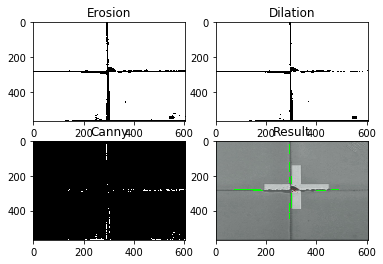

0 0
Error 數值有負，計算錯誤


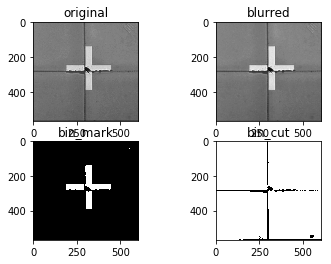

In [116]:
#using function(input,output,要不要顯示圖)
Image_processing_calculation('C:\\Users\\2102048\\pythonCV\\Screen\\OG\\cut_temp\\',
                            'C:\\Users\\2102048\\pythonCV\\Screen\\OG\\cut_result\\',
                            1)